In [ ]:
!pip install transformers -q

In [ ]:
import pandas as pd
import re
import string
from transformers import BertTokenizer, TFBertModel
import numpy as np
from sklearn import model_selection
from keras import layers
#from transformers import AutoModelForSequenceClassification

URL = 'https://drive.google.com/file/d/1fLX0XxkbSXatVevvndyqkBDxNOgWcUHP/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+URL.split('/')[-2]
#df = pd.read_pickle(path)
df = pd.read_csv(path)
df.head()

bert = TFBertModel.from_pretrained('bert-base-uncased', num_labels=2)
#bert = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', num_labels=2)


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
df_c = df.copy()
df_c=df_c.drop(columns=['keyword','id', 'location'])
df_c=df_c.dropna()

In [ ]:
df_c.text=df_c.text.apply(lambda x:x.lower() )
#removing square brackets
df_c.text=df_c.text.apply(lambda x:re.sub('\[.*?\]', '', x) )
df_c.text=df_c.text.apply(lambda x:re.sub('<.*?>+', '', x) )
#removing hyperlink
df_c.text=df_c.text.apply(lambda x:re.sub('https?://\S+|www\.\S+', '', x) )
#removing puncuation
df_c.text=df_c.text.apply(lambda x:re.sub('[%s]' % re.escape(string.punctuation), '', x) )
df_c.text=df_c.text.apply(lambda x:re.sub('\n' , '', x) )
#remove words containing numbers
df_c.text=df_c.text.apply(lambda x:re.sub('\w*\d\w*' , '', x) )

#df_c.iloc[:-10]

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


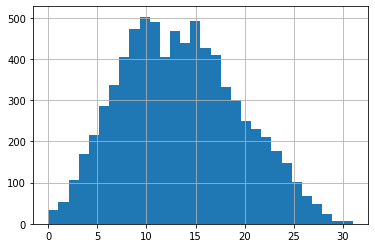

In [ ]:
raw_length = [len(i.split()) for i in df_c['text']]

pd.Series(raw_length).hist(bins = 30)

In [ ]:
print("max len of tweets",max([len(x.split()) for x in df_c['text']]))

max len of tweets 31


In [ ]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df_c['text'],df_c['target'],test_size=0.3)

In [ ]:
Train_Y

8487     0.0
153      0.0
5505     1.0
9576     0.0
7532     1.0
        ... 
10775    1.0
3936     1.0
3570     0.0
9434     0.0
1017     0.0
Name: target, Length: 5329, dtype: float64

In [ ]:
 x_1= tokenizer(
    text=Train_X.to_list(),
    add_special_tokens=True, #only in this case
    max_length=31, #not sure about this
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

y_1=Train_Y.to_numpy()
#y_1=Train_Y.values
#y_1 =tf.keras.utils.to_categorical(y_1, num_classes=2)
# test
 x_2= tokenizer(
    text=Test_X.to_list(),
    add_special_tokens=True, #only in this case
    max_length=31,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

y_2=Test_Y.to_numpy()
#y_2=Test_Y.values
#y_1 = np.asarray(y_1).astype('float32').reshape((-1,1))
#y_2 = np.asarray(y_2).astype('float32').reshape((-1,1))

#y_2 =tf.keras.utils.to_categorical(y_2, num_classes=2)

In [ ]:
x_1['attention_mask'].shape

TensorShape([5329, 31])

In [ ]:
y_1[3]

0.0

In [ ]:
x_1['input_ids'].shape

TensorShape([5329, 31])

In [ ]:
y_1.shape

(5329,)

In [ ]:
type (x_2)

transformers.tokenization_utils_base.BatchEncoding

In [ ]:
x_2

{'input_ids': <tf.Tensor: shape=(2284, 31), dtype=int32, numpy=
array([[  101,  2028,  2158, ...,     0,     0,     0],
       [  101,  2664,  2178, ...,     0,     0,     0],
       [  101,  7110,  2102, ...,     0,     0,     0],
       ...,
       [  101,  2256, 12508, ...,     0,     0,     0],
       [  101, 13879,  3475, ...,     0,     0,     0],
       [  101,  1045, 25430, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2284, 31), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

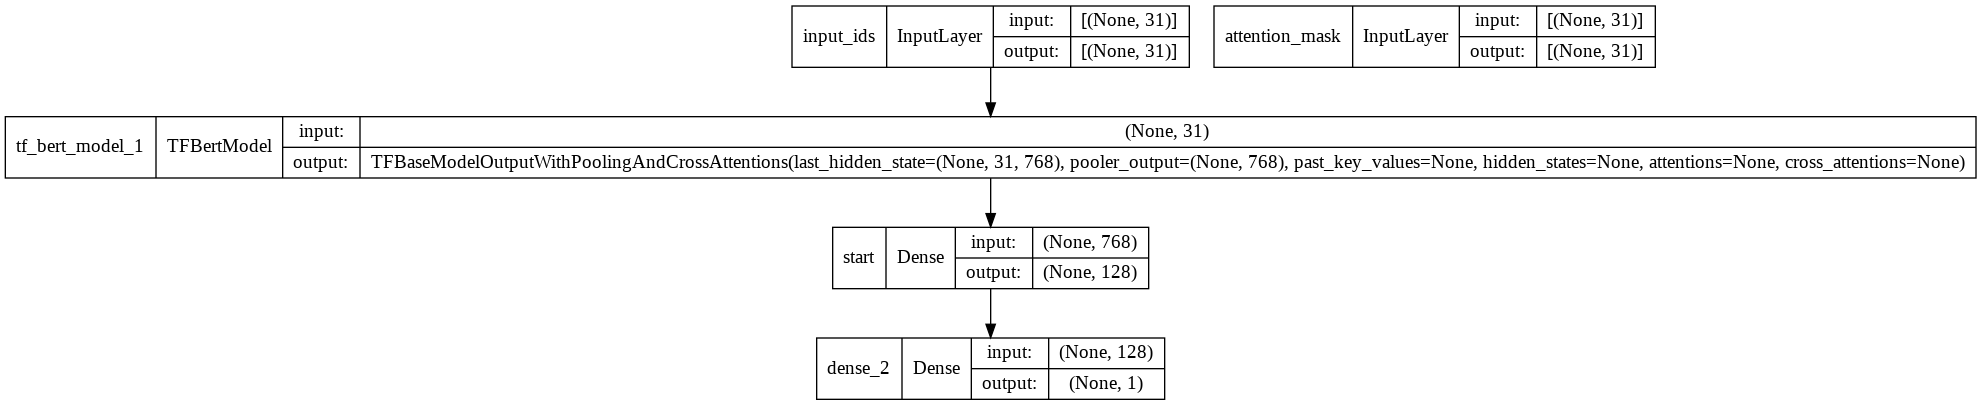

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
'''''

input_ids = keras.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = keras.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert(input_ids,attention_mask = input_mask)[1]
out = tf.keras.layers.Dropout(0.1)(embeddings)
out = keras.layers.Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = keras.layers.Dense(32,activation = 'relu')(out)
y = keras.layers.Dense(1,activation = 'sigmoid')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True
'''''
for layer in bert.layers:
  layer.trainable = False
## QA Model
max_len = 31 
input_ids = layers.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embedding = bert(
    input_ids,  attention_mask=attention_mask
)[1]
out = layers.Dense(128, name="start", activation = 'relu')(embedding)
outs = layers.Dense(1, activation = 'sigmoid')(out)

model = keras.Model(
    inputs=[input_ids, attention_mask]
    , outputs=outs
)
metrics = keras.metrics.BinaryAccuracy('accuracy')
loss = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adam(
    learning_rate==5e-5, # this learning rate is taken from huggingface website 
    #epsilon=1e-08,
    #decay=0.01,
    #clipnorm=1.0
    )
#optimizer =tf.keras.optimizers.SGD()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
plot_model(model, to_file='mod_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
'''''
optimizer = keras.optimizers.Adam(
    learning_rate=6e-06, # this learning rate is taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = keras.losses.BinaryCrossentropy(from_logits = True)
metric = keras.metrics.BinaryAccuracy('accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

#loss = keras.losses.BinaryCrossentropy(from_logits = False)
#from keras.optimizers import SGD
#optimizer = SGD(lr=0.01)
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)
model.compile(optimizer =optimizer, loss='categorical_crossentropy',
              metrics=['accuracy'])
'''''

In [ ]:
train_history = model.fit(
    x ={'input_ids':x_1['input_ids'],'attention_mask':x_1['attention_mask']} ,
    #x =x_1,
    y = y_1, epochs=7, batch_size=32
)

In [ ]:
''''
predicted = model.predict({'input_ids':x_2['input_ids'],'attention_mask':x_2['attention_mask']})
y_predicted = np.where(predicted>0.5,1,0)
y_predictedd = y_predicted.reshape((1,2284))[0]
'''''


In [ ]:
from sklearn.metrics import accuracy_score
y_pred = model.predict({'input_ids':x_2['input_ids'],'attention_mask':x_2['attention_mask']})
print("Accuracy:", accuracy_score(y_2, y_pred.round())) # Value between 0 and 1